<a href="https://colab.research.google.com/github/iremond/Progetto_HLT/blob/main/subtaskB/BERT_multilingual_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

!{sys.executable} -m pip install transformers[torch] datasets evaluate torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/HLT

/content/drive/MyDrive/HLT


In [4]:
from datasets import load_dataset, Features, Value, ClassLabel
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertConfig, AutoConfig
import numpy as np
import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data loading

In [5]:
df_dev = load_dataset("csv", data_files="dataset/subtaskB_clean_dev_cased.csv")#, column_names=['text', 'label'])#, features=features)
df_test = load_dataset("csv", data_files="dataset/subtaskB_clean_test_cased.csv")#, column_names=['text', 'label'])#, features=features)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [6]:
df_dev = df_dev.rename_column("comment_text", "text")
df_dev = df_dev.rename_column("topic", "label")
df_test = df_test.rename_column("comment_text", "text")

In [7]:
class_names = ['Covid', 'Qanon', 'Russia', 'Terra Piatta']

In [8]:
label = ClassLabel(num_classes=4, names=class_names)
#features = Features({'text': Value('string'), 'label': ClassLabel(num_classes=4, names=class_names)})

In [9]:
df_dev = df_dev.cast_column("label", label)

Casting the dataset:   0%|          | 0/810 [00:00<?, ? examples/s]

In [10]:
df_dev

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 810
    })
})

In [11]:
np.unique(df_dev['train']['label'], return_counts=True)

(array([0, 1, 2, 3]), array([435, 242,  57,  76]))

# Data partioning

In [12]:
train_val = df_dev['train'].train_test_split(test_size=0.3, seed=42, stratify_by_column='label')
train_val

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 567
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 243
    })
})

In [13]:
df_train = train_val["train"]
df_val = train_val["test"]

In [14]:
df_val

Dataset({
    features: ['text', 'label'],
    num_rows: 243
})

In [15]:
np.unique(df_val['label'], return_counts=True)

(array([0, 1, 2, 3]), array([130,  73,  17,  23]))

# Model loading

In [16]:
nome = 'bert_base'
model_name = 'bert-base-multilingual-cased'

In [17]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Data preprocessing

In [18]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [19]:
tokenized_train = df_train.map(tokenize_function, batched=True)
tokenized_val = df_val.map(tokenize_function, batched=True)
tokenized_test = df_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/567 [00:00<?, ? examples/s]

Map:   0%|          | 0/243 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [20]:
tokenized_train

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 567
})

In [21]:
# small_train_dataset = tokenized_train.shuffle(seed=42).select(range(6))
# small_eval_dataset = tokenized_val.shuffle(seed=42).select(range(3))

# Training

In [22]:
label2id = {
    "Covid": 0,
    "QAnon": 1,
    "Russia": 2,
    "Terra Piatta": 3
}

In [23]:
id2label = {
    "0": 'Covid',
    "1": 'QAnon',
    "2": 'Russia',
    "3": 'Terra Piatta'
}

In [24]:
training_args = TrainingArguments(
    output_dir=f"{nome}-finetuned",
    evaluation_strategy = "epoch", # monitor the evaluation metrics during fine-tuning at the end of each epoch
    save_strategy = "epoch",
    logging_strategy="epoch",
    num_train_epochs=15,
    load_best_model_at_end=True, # the best model might not be the one at the end of training => we load the best saved model
    metric_for_best_model='eval_f1',
    seed=42
    #per_device_train_batch_size # default 8
    #per_device_eval_batch_size # default 8
    #learning_rate=0.0005, # default 0.00005
    #weight_decay=0.0001 # default 0 # disastro
    )

In [25]:
config = AutoConfig.from_pretrained(model_name, num_labels=len(label2id))
config.id2label = id2label
config.label2id = label2id


In [26]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)#, num_labels=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [28]:
model.config

BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Covid",
    "1": "QAnon",
    "2": "Russia",
    "3": "Terra Piatta"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Covid": 0,
    "QAnon": 1,
    "Russia": 2,
    "Terra Piatta": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.31.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 11

In [29]:
def compute_metrics(eval_pred):
  # takes as input model predictions, applies argmax to them and comput F-Score between predictions and true labels
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [30]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics
)

In [31]:
%%time
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.841400,0.571368,0.738971
2,0.640700,0.695360,0.687868
3,0.421300,0.588742,0.809727
4,0.258000,0.873870,0.793670
5,0.229800,0.882365,0.763562
6,0.125100,0.980426,0.822169
7,0.031600,1.049722,0.830532


Epoch,Training Loss,Validation Loss,F1
1,0.841400,0.571368,0.738971
2,0.640700,0.695360,0.687868
3,0.421300,0.588742,0.809727
4,0.258000,0.873870,0.793670
5,0.229800,0.882365,0.763562
6,0.125100,0.980426,0.822169
7,0.031600,1.049722,0.830532
8,0.052500,1.097944,0.805387
9,0.024400,1.101146,0.800061
10,0.000800,1.206524,0.809032


CPU times: user 14min 36s, sys: 56.2 s, total: 15min 32s
Wall time: 26min 40s


TrainOutput(global_step=1065, training_loss=0.17531525202690157, metrics={'train_runtime': 1599.6514, 'train_samples_per_second': 5.317, 'train_steps_per_second': 0.666, 'total_flos': 2237799709716480.0, 'train_loss': 0.17531525202690157, 'epoch': 15.0})

# Evaluation

In [32]:
log_history = trainer.state.log_history

In [33]:
df = pd.DataFrame(columns=["Epoch", "Loss", "Dataset"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
df

<ipython-input-33-ea7900ceb47e>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
<ipython-input-33-ea7900ceb47e>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
<ipython-input-33-ea7900ceb47e>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
<ipython-input-33-ea7900ceb47e>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Da

,Epoch,Loss,Dataset
0,1,0.841400,Training
1,1,0.571368,Validation
2,2,0.640700,Training
3,2,0.695360,Validation
4,3,0.421300,Training
5,3,0.588742,Validation
6,4,0.258000,Training
7,4,0.873870,Validation
8,5,0.229800,Training
9,5,0.882365,Validation


In [34]:
from IPython.display import HTML

df.to_html(f'subtaskB/loss_{nome}.html')

display(HTML(f'subtaskB/loss_{nome}.html'))

,Epoch,Loss,Dataset
0,1,0.841400,Training
1,1,0.571368,Validation
2,2,0.640700,Training
3,2,0.695360,Validation
4,3,0.421300,Training
5,3,0.588742,Validation
6,4,0.258000,Training
7,4,0.873870,Validation
8,5,0.229800,Training
9,5,0.882365,Validation


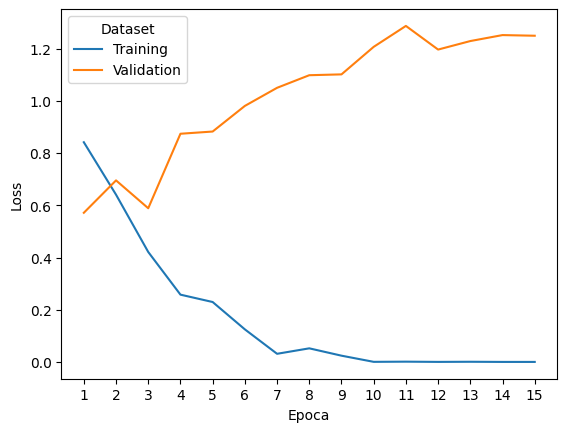

In [35]:
# loss lineplot
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Dataset")
plt.xticks(range(1, 16))
plt.xlabel('Epoca')
plt.savefig(f'subtaskB/loss_curves_{nome}.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
output_predictions = trainer.predict(tokenized_val)

In [37]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [38]:
y_val = tokenized_val["label"]
y_val_pred = np.argmax(output_predictions.predictions, axis=1)

report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       130
           1       0.74      0.78      0.76        73
           2       0.75      0.71      0.73        17
           3       1.00      0.91      0.95        23

    accuracy                           0.84       243
   macro avg       0.84      0.82      0.83       243
weighted avg       0.84      0.84      0.84       243



In [39]:
with open(f"subtaskB/class_report_{nome}.html", "w") as file:
    file.write(report)

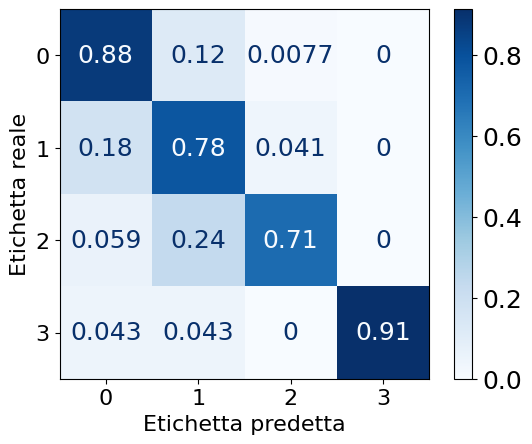

In [40]:
plt.rcParams.update({'font.size': 18})
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, cmap='Blues', normalize='true')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Etichetta predetta', fontsize=16)
plt.ylabel('Etichetta reale', fontsize=16)
plt.savefig(f'subtaskB/conf_matrix_{nome}.pdf', dpi=300, bbox_inches='tight')
plt.show()